In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py

import lal
import lalsimulation

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

# Construct surrogate in way that can be directly converted to lalsuite code

In [4]:
def kernel(x1, x2, hyperparams):
    """Matern covariance function for n-dimensional data.
    
    Parameters
    ----------
    x1 : array with shape ndim
    x2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        lsi : Length scales for the variation in dimension i.
    
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[-1]
    ls = hyperparams[1:-1]
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(x1, x2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    #nugget = sigma_n**2
    
    # r**2
    rsq = np.sum(np.array([(x1[i]-x2[i])**2 / ls[i]**2 for i in range(ndim)]))
    r = np.sqrt(rsq)
    
    # nu = 5/2 Matern covariance
    matern = (1. + np.sqrt(5.)*r + 5.*r**2/3.) * np.exp(-np.sqrt(5.)*r)
    
    # Full covariance
    # You must include the nugget to agree with scikit-learn when the points x1, x2 are exactly the same
    return sigma_f**2 * matern + nugget

In [5]:
def gp_predict(xst, hyperparams, x_train, Kinv_dot_y):
    """Interpolate the function at the point xst using Gaussian process regression.
    
    Parameters
    ----------
    xst : array of shape ndim.
        Point x_* where you want to evaluate the function.
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n].
        Hyperparameters for the GPR kernel.
    x_train : array of shape (n_train, ndim).
        Training set points.
    Kinv_dot_y : array of shape n_train.
        The interpolating weights at each training set point.
    
    Returns
    -------
    yst : float
        Interpolated value at the point xst.
    """
    # Evaluate vector K_*
    Kst = np.array([kernel(xst, x, hyperparams) for x in x_train])

    # Evaluate y_*
    return np.dot(Kst, Kinv_dot_y)

In [6]:
def extract_data_from_scikit_learn(gp):
    """Extract the data in the scikit-learn GaussianProcessRegressor class 
    that you need for the lalsuite version.
    """
    # hyperparams = np.array([sigma_f, lq, ls1, ls2, llam1, llam2, sigma_n])
    hyperparams = gpr.get_hyperparameters(gp)
    
    # The training data
    x_train = gp.X_train_
    y_train = gp.y_train_
    
    # Evaluate K
    K = np.array([[kernel(x1, x2, hyperparams) for x2 in x_train] for x1 in x_train])
    
    # Evaluate K^{-1}
    Kinv = np.linalg.inv(K)
    
    # Evaluate (K^{-1})_{ij} y_j (array of length nparams).
    Kinv_dot_y = np.dot(Kinv, y_train)
    
    return hyperparams, x_train, Kinv_dot_y

# Load scikit-learn (python) version of surrogate

In [7]:
gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uncsamp_uniform_xi.hdf5'
gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uncsamp_uniform_xi.hdf5'
nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uncsamp_uniform_xi.hdf5'
sur = surrogate.GPSplineSurrogate.load(
    nodes_filename, gp_amp_filename, gp_phase_filename, 
    order=3, npoints=1000, quad1=None, quad2=None, spin_spin=False)

In [9]:
# Is there an alpha = 1.0e-10 term in the scikit-learn version?

def xi_of_lam(lam, a=100):
    return np.log10(lam/a + 1)

#Random point:
x = np.array([0.8, 0.2, 0.1, xi_of_lam(1000), xi_of_lam(2000)])

# Point exactly in training set:
#x = np.array([1.0, 0.5, 0.5, 0.0, 0.0])

for i in range(len(sur.damp_gp_list)):
    gp = sur.damp_gp_list[i]
    gp.alpha = 0.0
    #gp.alpha_ *= 0.0
    #gp = sur.dphase_gp_list[0]
    hyperparams, x_train, Kinv_dot_y = extract_data_from_scikit_learn(gp)

    a = gp.predict(np.atleast_2d(x))[0]
    b = gp_predict(x, hyperparams, x_train, Kinv_dot_y)

    sigma_n = hyperparams[-1]
    print sigma_n
    print a, b, np.abs(b/a-1.), np.abs(b-a)

1.5514481878367244e-08
3.303454287495455e-05 3.3062098842684406e-05 0.0008341561690186072 2.7555967729853137e-08
1.72950994772987e-08
2.7104614895507792e-05 2.855969959902893e-05 0.05368402056737209 1.4550847035211395e-06
2.0429888481790192e-08
1.3043824243524904e-05 1.3879453399034958e-05 0.06406320262440435 8.356291555100537e-07
2.4242850499042553e-08
-8.687950126477773e-06 -8.048808140870278e-06 0.07356648879228911 6.391419856074942e-07
2.8743246476212455e-08
-3.940004094478075e-05 -3.9729494013540645e-05 0.008361744324622 3.29453068759894e-07
3.4112850448840424e-08
-7.94427122166319e-05 -7.472725443236072e-05 0.05935670689858408 4.715457784271182e-06
4.057612035584173e-08
-0.00013782991259294122 -0.00013890794207505053 0.007821447912349067 1.078029482109305e-06
4.829107838917363e-08
-0.0002125728775724811 -0.00021252213629097128 0.0002387006380554224 5.0741281509836256e-08
5.755127387693948e-08
-0.00031209905878599314 -0.00031149172087818755 0.0019459780179024166 6.07337907805594e-

KeyboardInterrupt: 

# Generate hdf5 file for lalsuite version

In [11]:
def lalsuite_spline_surrogate_format(filename, sur):
    """Write data to an hdf5 file format that can be read by the 
    lalsuite version of the code.
    """
    f = h5py.File(filename, libver='latest')
    
    namp = len(sur.damp_gp_list)
    nphase = len(sur.dphase_gp_list)
    
    # Make sure 'Description' is capitalized for LAL
    f.attrs['Description'] = \
'''
********************************************************************************
Data for the SEOBNRv4T_surrogate waveform. 
Aligned-spin BNS with tidal interactions and the spin-induced quadrupole moment
that is linked to the tidal deformability via universal relations.

See B. Lackey, M. Puerrer, A. Taracchini, S. Marsat. arXiv:xxxx.xxxx.

Parameter ranges:
* 1.0/3.0 <= q <= 1.0
* -0.5 <= spin_1z <= 0.5
* -0.5 <= spin_2z <= 0.5
* 0.0 <= lambda_1 <= 5000.0
* 0.0 <= lambda_2 <= 5000.0

The first spline node for dphase is not listed since it is the same as the first
node for damp, and dphase = 0 for the first node.

The hyperparameters for the Gaussian process regression associated with each 
basis function are listed in the order
[sigma_f, l_q, l_spin1z, l_spin2z, l_xi1, l_xi2, sigma_n]
where sigma_f is approximately the function range, sigma_n is the noise/tolerance, 
and l_i is the correlation length scale for the parameter i.

Note, the GPR fit is done in terms of xi1, xi2 instead of lambda1, lambda2, where
xi = log10(lambda/100 + 1).
********************************************************************************
'''
    
    f.attrs['Creator'] = 'Ben Lackey, Michael Puerrer, Andrea Taracchini, Sylvain Marsat'
    f.attrs['Email'] = 'benjamin.lackey@ligo.org, michael.puerrer@ligo.org'
    f.attrs.create('version_major', 1, dtype='i4')
    f.attrs.create('version_minor', 0, dtype='i4')
    f.attrs.create('version_micro', 0, dtype='i4')
    
    # Bounds
    # To be read properly from LAL, make sure that all bounds are arrays of floats *not* integers.
    f['q_bounds'] = np.array([1.0/3.0, 1.0])
    f['chi1_bounds'] = np.array([-0.5, 0.5])
    f['chi2_bounds'] = np.array([-0.5, 0.5])
    f['lambda1_bounds'] = np.array([0.0, 5000.0])
    f['lambda2_bounds'] = np.array([0.0, 5000.0])

    # Nodes for splines.
    f['spline_nodes_amp'] = sur.mf_amp
    f['spline_nodes_phase'] = sur.mf_phase
    
    print f['spline_nodes_amp'][:].shape
    print f['spline_nodes_phase'][:].shape
    
    # Nodes for splines of final waveform
    npoints = 1000
    mfs = np.logspace(-5.0, np.log10(sur.mf_phase[-1]), npoints)
    f['TF2_Mf_amp_linear'] = mfs
    f['TF2_Mf_phi_linear'] = mfs
    f['TF2_Mf_amp_cubic'] = mfs
    f['TF2_Mf_phi_cubic'] = mfs
    
    print mfs[0], mfs[-1]
    print f['TF2_Mf_amp_linear'][:].shape

    # Training set samples.
    # They are the same for all basis functions so pick amp_0
    gp = sur.damp_gp_list[0]
    x_train = gp.X_train_
    f['x_train'] = x_train
    
    print 'Writing amplitude bases...'
    hyp_amp = []
    kinv_dot_y_amp = []
    for i in range(namp):
        print i, 
        gp = sur.damp_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        hyp_amp.append(hyperparameters)
        kinv_dot_y_amp.append(kinv_dot_y)
    
    f['hyp_amp'] = np.array(hyp_amp)
    f['kinv_dot_y_amp'] = np.array(kinv_dot_y_amp)
    
    print f['hyp_amp'][:].shape
    print f['kinv_dot_y_amp'][:].shape
    
    
    print '\nWriting phase bases...'
    hyp_phase = []
    kinv_dot_y_phase = []
    for i in range(nphase):
        print i, 
        gp = sur.dphase_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        hyp_phase.append(hyperparameters)
        kinv_dot_y_phase.append(kinv_dot_y)
    
    f['hyp_phi'] = np.array(hyp_phase)
    f['kinv_dot_y_phi'] = np.array(kinv_dot_y_phase)
    
    print f['hyp_phi'][:].shape
    print f['kinv_dot_y_phi'][:].shape
    
    f.close()

In [12]:
filename = '../../data/TEOBv4QM_production/SEOBNRv4T_surrogate_v1.0.0.hdf5'
lalsuite_spline_surrogate_format(filename, sur)

(40,)
(39,)
1e-05 0.07000000000000002
(1000,)
Writing amplitude bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 (40, 7)
(40, 960)

Writing phase bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 (39, 7)
(39, 960)


## Testing

In [13]:
%%bash
#h5ls ../../data/TEOBv4QM_20hz/SEOBNRv4T_surrogate_v1.0.0.hdf5
#h5dump -n 1 ../../data/TEOBv4QM_20hz/SEOBNRv4T_surrogate_v1.0.0.hdf5
h5dump -a Description /Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/SEOBNRv4T_surrogate_v1.0.0.hdf5

h5dump error: unable to open file "/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/SEOBNRv4T_surrogate_v1.0.0.hdf5"


# Compare TaylorF2 to lalsimulation version

In [7]:
# Note: these functions are not callable outside this source file, even though they are XLAL
# Therefore I reimplement them here.
# See LALSimInspiralPNCoefficients.c

def XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(mByM):
    return (-288. + 264.*mByM)*mByM*mByM*mByM*mByM;

def XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(mByM):
    return (-15895./28. + 4595./28.*mByM + 5715./14.*mByM*mByM - 325./7.*mByM*mByM*mByM)*mByM*mByM*mByM*mByM;

In [98]:
def pn_phase_lal(mfs, eta, chi1, chi2, lambda1, lambda2, quad1, quad2):
    """This is essentially the way LALSimulation calculates the TaylorF2 phase array.
    """
    d = np.sqrt(1.0-4.0*eta)
    X1 = 0.5*(1.0+d)
    X2 = 0.5*(1.0-d)
    
    # Fake masses
    mtot = 2.0
    m1 = X1*mtot
    m2 = X2*mtot
    
    # Specify PN order for spin terms
    extraParams = lal.CreateDict()
    lalsimulation.SimInspiralWaveformParamsInsertPNSpinOrder(
        extraParams, lalsimulation.SIM_INSPIRAL_SPIN_ORDER_35PN)
    
    # Add spin-induced quadrupole terms
    # dQuadMon1 = quad1 - 1
    # dQuadMon2 = quad2 - 1
    lalsimulation.SimInspiralWaveformParamsInsertdQuadMon1(extraParams, quad1-1.0)
    lalsimulation.SimInspiralWaveformParamsInsertdQuadMon2(extraParams, quad2-1.0)
    
    print lalsimulation.SimInspiralWaveformParamsLookupdQuadMon1(extraParams)
    print lalsimulation.SimInspiralWaveformParamsLookupdQuadMon2(extraParams)
    
    # Calculate coefficients of each power of v
    pn = lalsimulation.SimInspiralTaylorF2AlignedPhasing(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, chi1, chi2, extraParams)
    #print pn.v
    
    # Manually add the tidal parameters
    
    pn.v[10] = pn.v[0]*(lambda1*XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(X1)
                        + lambda2*XLALSimInspiralTaylorF2Phasing_10PNTidalCoeff(X2))
    pn.v[12] = pn.v[0]*(lambda1*XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(X1)
                        + lambda2*XLALSimInspiralTaylorF2Phasing_12PNTidalCoeff(X2))
    
    print pn.v[0]
    print pn.v/pn.v[0]
    print pn.vlogv/pn.v[0]/2
    print pn.v[10]/pn.v[0], pn.v[12]/pn.v[0]
    
    phases = []
    for mf in mfs:
        v = (lal.PI * mf)**(1.0/3.0)
        logv = log(v)
    
        v2 = v * v;
        v3 = v * v2;
        v4 = v * v3;
        v5 = v * v4;
        v6 = v * v5;
        v7 = v * v6;
        v8 = v * v7;
        v9 = v * v8;
        v10 = v * v9;
        v12 = v2 * v10;
        phasing = 0.0;
        
        phasing += pn.v[7] * v7;
        phasing += (pn.v[6] + pn.vlogv[6] * logv) * v6;
        phasing += (pn.v[5] + pn.vlogv[5] * logv) * v5;
        phasing += pn.v[4] * v4;
        phasing += pn.v[3] * v3;
        phasing += pn.v[2] * v2;
        phasing += pn.v[1] * v;
        phasing += pn.v[0];
        
        # Tidal terms in phasing
        phasing += pn.v[12] * v12;
        phasing += pn.v[10] * v10;
        
        phasing /= v5;
        phases.append(phasing)
    
    return np.array(phases)

In [99]:
# Check that you reproduce the LALSimulation version to double precision

#x = np.array([0.46, 0.0, 0.0, 5000, 500])
#x = np.array([0.46, -0.7, 0.2, 5000, 500])
x = np.array([1.0/3.0, -0.5, -0.5, 5000, 5000])
mf = np.logspace(-5, -2, 5)
tbymc = 0
phic = 0

q, chi1, chi2, lambda1, lambda2 = x
eta = q/(1.0+q)**2

In [100]:
quad1 = 1.0
quad2 = 1.0

print 'lalsuite: '
lal_phase = pn_phase_lal(mf, eta, chi1, chi2, lambda1, lambda2, quad1, quad2)

print '\nBen: '
ben_phase = -f2.taylorf2_phase(mf, tbymc, phic, eta, chi1, chi2, lambda1, lambda2, quad1, quad2)+np.pi/4

print '\nFractional difference: '
print lal_phase
print ben_phase
print lal_phase - ben_phase
print lal_phase/ben_phase - 1.0

lalsuite: 
0.0
0.0
0.125
[  1.000000e+00   0.000000e+00   6.059854e+00  -6.672382e+01   2.916902e+01   2.891869e+02  -1.887921e+03
   3.921183e+03   0.000000e+00   0.000000e+00  -1.467188e+05   0.000000e+00  -3.808908e+05]
[   0.          0.          0.          0.          0.        433.780314 -163.047619    0.          0.          0.
    0.          0.          0.      ]
-146718.75 -380890.764509

Ben: 
1.0 1.0

Fractional difference: 
[  4.011828e+06   2.261518e+05   1.237551e+04   4.330969e+02  -1.801003e+02]
[  4.011828e+06   2.261518e+05   1.237551e+04   4.330969e+02  -1.801003e+02]
[  1.396984e-09   5.820766e-11  -5.456968e-12   0.000000e+00  -2.842171e-14]
[  4.440892e-16   2.220446e-16  -4.440892e-16   0.000000e+00   2.220446e-16]


In [101]:
quad1 = f2.quad_of_lambda_fit(lambda1)
quad2 = f2.quad_of_lambda_fit(lambda2)

print 'lalsuite: '
lal_phase = pn_phase_lal(mf, eta, chi1, chi2, lambda1, lambda2, quad1, quad2)

print '\nBen: '
ben_phase = -f2.taylorf2_phase(mf, tbymc, phic, eta, chi1, chi2, lambda1, lambda2, quad1, quad2)+np.pi/4

print '\nFractional difference: '
print lal_phase
print ben_phase
print lal_phase - ben_phase
print lal_phase/ben_phase - 1.0

lalsuite: 
10.8705502655
10.8705502655
0.125
[  1.000000e+00   0.000000e+00   6.059854e+00  -6.672382e+01  -5.575715e+01   2.891869e+02  -4.597058e+02
   3.921183e+03   0.000000e+00   0.000000e+00  -1.467188e+05   0.000000e+00  -3.808908e+05]
[   0.          0.          0.          0.          0.        433.780314 -163.047619    0.          0.          0.
    0.          0.          0.      ]
-146718.75 -380890.764509

Ben: 
11.8705502655 11.8705502655

Fractional difference: 
[  4.011498e+06   2.259727e+05   1.228693e+04   4.049470e+02  -1.574120e+02]
[  4.011498e+06   2.259727e+05   1.228693e+04   4.049470e+02  -1.574120e+02]
[  2.328306e-09   0.000000e+00  -5.456968e-12   1.136868e-13  -2.842171e-14]
[  6.661338e-16   0.000000e+00  -4.440892e-16   2.220446e-16   2.220446e-16]


# Compare TaylorF2 to LALSimulation h+, hx output

In [89]:
mf = np.logspace(np.log10(0.00021), np.log10(0.07), 1000)

In [90]:
mf_min = mf[0]
mf_max = mf[-1]
hlal = lalwaveform.dimensionless_fd_waveform(
    approximant='TaylorF2', 
    q=q, spin1z=chi1, spin2z=chi2, lambda1=lambda1, lambda2=lambda2, quad1=quad1, quad2=quad2,
    mf_min=mf_min, mf_max=mf_max, delta_mf=1.0e-8)
hlal.add_phase(remove_start_phase=True)
lal_phase = hlal.interpolate('phase')(mf)

print hlal.phase.shape

11.8705502655 11.8705502655
(6979001,)


In [91]:
ben_phase = f2.taylorf2_phase(mf, tbymc, phic, eta, chi1, chi2, lambda1, lambda2, quad1, quad2)
ben_phase -= ben_phase[0]

11.8705502655 11.8705502655


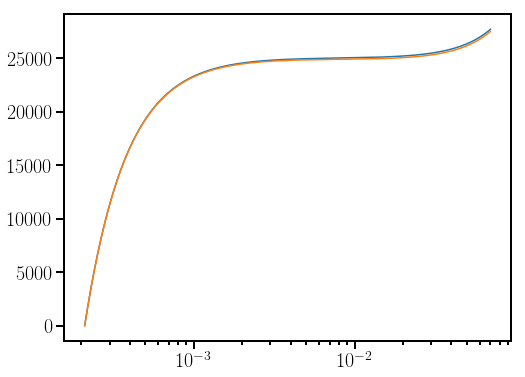

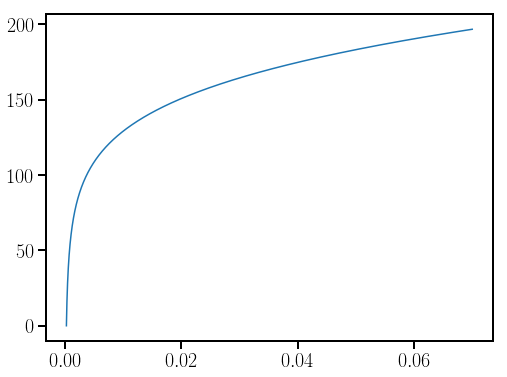

In [92]:
fig, ax = plt.subplots()
ax.plot(mf, lal_phase)
ax.plot(mf, ben_phase)
ax.set_xscale('log')

fig, ax = plt.subplots()
ax.plot(mf, lal_phase-ben_phase)
#ax.set_xscale('log')